In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import trange

In [2]:
def dvdt(t, v, x1, x2):
    v1, v2 = tf.split(v, 2) 
    dv1dt = x1[tf.cast(tf.round(t), tf.int32)] -2*v1 + 8*v2 - x1[tf.cast(tf.round(t), tf.int32)]*v1
    dv2dt = x2[tf.cast(tf.round(t), tf.int32)] -5*v1 + v2 - x2[tf.cast(tf.round(t), tf.int32)]*v2
    dvdt = tf.concat([dv1dt, dv2dt], axis=0)
    return dvdt 

In [3]:
def generate_xs(nt):
    
    # initial values 
    x1 = np.absolute(np.array([np.random.uniform(low=-0.5, high=0.5)]))
    x2 = np.absolute(np.array([np.random.uniform(low=-1.0, high=1.0)]))

    for i in range(nt): 
        # generate a bernouilli according to PD
        p1 = np.random.binomial(1,p=0.65)
        p2 = np.random.binomial(1,p=0.99)
        u1 = np.absolute(np.array([np.random.uniform(low=-0.5, high=0.5)]))
        u2 = np.absolute(np.array([np.random.uniform(low=-1.0, high=1.0)]))
        x1 = np.append(x1, x1[-1]+p1*u1, axis=0)
        x2 = np.append(x2, x2[-1]+p2*u2, axis=0)
    return x1, x2

In [4]:
ODESolver = tfp.math.ode.DormandPrince()

# initial conditions and time grid
t_initial = 0 # initial time
t_final = 8 # final time
n_times = 80 # number of time steps to churn out solution for
times = np.linspace(t_initial, t_final, n_times).astype(np.float32)

# generate trajectories
n_trajectories = 100
trajectories = []
xs = []
for i in range(n_trajectories):
    # initial conditions
    v_initial = np.random.uniform(low=-1.0, high=1.0, size=2).astype(np.float32)

    # xs
    x1, x2 = generate_xs(n_times)
    
    # integrate the ODE
    results = ODESolver.solve(dvdt, # system of ODEs (gradient function)
                                       t_initial, # initial time
                                       v_initial, # initial state
                                       solution_times=times,
                                       constants={'x1': x1.astype(np.float32),'x2': x2.astype(np.float32)}) # time grid to spit out solutions for

    # extract results for the state solutions v(t)
    data = tf.stack(results.states, axis=0)
    
    # append
    trajectories.append(data)
    xs.append(tf.stack([x1, x2], axis=-1))
    
trajectories = tf.stack(trajectories, axis=0)
xs = tf.stack(xs, axis=0)

In [34]:
class RecurrentNetworkODE(tf.keras.Model):
    """
    RNN ODE model (a la Bailer Jones et al)
    """

    def __init__(self, n_dimensions, n_inputs, n_hidden=128, activation=tf.tanh, optimizer=tf.keras.optimizers.Adam(), solver=tfp.math.ode.DormandPrince()):
        
        # super
        super(RecurrentNetworkODE, self).__init__()
        
        self.n_dimensions = n_dimensions
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.activation = activation
        self.optimizer = optimizer
        
        # weights and biases
        self.W1x = tf.Variable(tf.random.normal([n_inputs, n_hidden], 0, 1e-3))
        self.W1v = tf.Variable(tf.random.normal([n_dimensions, n_hidden], 0, 1e-3))
        self.b1 = tf.Variable(tf.random.normal([n_hidden], 0, 1e-3))
        self.W2 = tf.Variable(tf.random.normal([n_hidden, n_dimensions], 0, 1e-3))
        self.b2 = tf.Variable(tf.random.normal([n_dimensions], 0, 1e-3))
        
        # ODE solver
        self.ODESolver = solver
    
    # call just calculates the derivative
    @tf.function
    def call(self, t, v, x):
        
        return tf.matmul(self.activation(tf.matmul(v, self.W1v) + tf.matmul(x, self.W1x) + self.b1), self.W2) + self.b2

    # same derivative function as above, but for single (rather than batch) t, v and x inputs, ie in form required by the ODE Solver
    @tf.function
    def dvdt(self, t, v, x):
        
        return tf.squeeze(tf.matmul(self.activation(tf.matmul(tf.expand_dims(v, 0), self.W1v) + tf.matmul(tf.expand_dims(x[tf.cast(tf.round(t), tf.int32)], 0), self.W1x) + self.b1), self.W2) + self.b2, 0)
    
    # ODE trajectories using Euler steps
    @tf.function
    def trajectories_euler(self, v0, x, t):
        
        # number of time steps
        nt = t.shape[-1]
        
        # initialize state (init zeros for all but initial conditions)
        v = [v0] + [tf.zeros([self.n_dimensions]) for _ in range(nt-1)]
        
        # euler steps
        for k in range(1, nt):
            v[k] = v[k-1] + self.call(t[k], v[k-1], x[:,tf.cast(tf.round(t[k]), tf.int32),:])*(t[k]-t[k-1])
            
        # stack the outputs into full trajectories
        return tf.stack(v, axis=1)
    
    # ODE trajectories using full solver
    @tf.function
    def trajectories_ode(self, v0, x, t):
        
        results = self.ODESolver.solve(self.dvdt, # system
                           t[0], # initial time
                           v0, # initial state
                           solution_times=t,
                           constants={'x': x})
        
        return tf.stack(results.states, axis=0)

In [35]:
model = RecurrentNetworkODE(2, 2, n_hidden=128, activation=tf.tanh)

In [36]:
epochs = 10000
v0 = tf.constant(trajectories[:,0,:])
times = tf.constant(times)
x = tf.cast(xs[:,1:,:], tf.float32)

with trange(epochs) as t:
    for epoch in t:
        
        with tf.GradientTape() as tape:
            tape.watch(model.trainable_variables)
            predicted_trajectories = model.trajectories_euler(v0, x, times)
            loss = tf.reduce_mean(tf.math.squared_difference(trajectories, predicted_trajectories))
        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        t.set_postfix(loss=loss.numpy())

  1%|          | 74/10000 [00:08<18:25,  8.98it/s, loss=0.0835] 


KeyboardInterrupt: 

In [37]:
predicted_trajectories = model.trajectories_euler(v0, x, times)

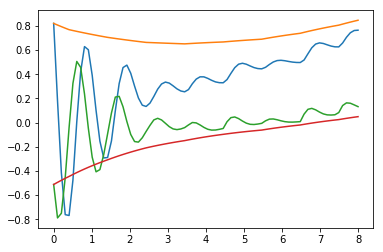

In [38]:
i = 13
plt.plot(times, trajectories[i,:,0])
plt.plot(times, predicted_trajectories[i,:,0])

plt.plot(times, trajectories[i,:,1])
plt.plot(times, predicted_trajectories[i,:,1])

plt.show()

In [41]:
epochs = 10000
v0 = tf.constant(trajectories[:,0,:])
times = tf.constant(times)
x = tf.cast(xs[:,1:,:], tf.float32)

with trange(epochs) as t:
    for epoch in t:
        
        with tf.GradientTape() as tape:
            tape.watch(model.trainable_variables)
            predicted_trajectories = tf.stack([model.trajectories_ode(v0[i], x[i], times) for i in range(x.shape[0])], axis=0)
            loss = tf.reduce_mean(tf.math.squared_difference(trajectories, predicted_trajectories))
        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        t.set_postfix(loss=loss.numpy())

  0%|          | 0/10000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


  0%|          | 4/10000 [03:40<153:21:18, 55.23s/it, loss=0.0802]


KeyboardInterrupt: 